# Importing Libraries 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, concatenate, BatchNormalization, MultiHeadAttention, LayerNormalization, LeakyReLU, Flatten,
                                      Embedding, Lambda, Add,  Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional, LSTM)
from tensorflow.keras.optimizers import Adam
import json
import os

# Data Loading and Exploration

In [2]:
excel_path = r'c:/Users/LENOVO/OneDrive/Desktop/capstone project/13059_2018_1459_MOESM5_ESM.xlsx'
xls = pd.ExcelFile(excel_path)
sheets = xls.sheet_names
dfs = {sheet: xls.parse(sheet) for sheet in sheets}

hct116_df=dfs['hct116']
hek293t_df=dfs['hek293t']
hela_df=dfs['hela']
hl60_df=dfs['hl60']

In [3]:
print(f'HCT116 shape: {hct116_df.shape}')
print(f'HEK293T shape: {hek293t_df.shape}')
print(f'HELA shape: {hela_df.shape}')
print(f'HL60 shape: {hl60_df.shape}')

HCT116 shape: (4239, 6)
HEK293T shape: (2333, 6)
HELA shape: (8101, 6)
HL60 shape: (2076, 6)


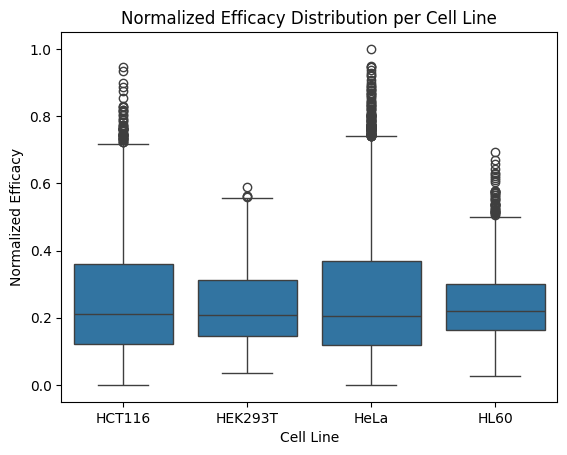

In [4]:
combined_df = pd.concat([
    hct116_df.assign(CellLine='HCT116'),
    hek293t_df.assign(CellLine='HEK293T'),
    hela_df.assign(CellLine='HeLa'),
    hl60_df.assign(CellLine='HL60')
])

sns.boxplot(data=combined_df, x='CellLine', y='Normalized efficacy')
plt.title('Normalized Efficacy Distribution per Cell Line')
plt.ylabel('Normalized Efficacy')
plt.xlabel('Cell Line')
plt.show()

In [5]:
'''
hct116_df.to_csv('hct116.csv', index=False)
hek293t_df.to_csv('hek293t.csv', index=False)
hela_df.to_csv('hela_df.csv', index=False)
hl60_df.to_csv('hl60_df.csv', index=False)
'''

"\nhct116_df.to_csv('hct116.csv', index=False)\nhek293t_df.to_csv('hek293t.csv', index=False)\nhela_df.to_csv('hela_df.csv', index=False)\nhl60_df.to_csv('hl60_df.csv', index=False)\n"

In [6]:
df=hct116_df.copy()

In [7]:
print("Max:", round(df['Normalized efficacy'].max(),3))
print("Min:", round(df['Normalized efficacy'].min(),3))

p1 = df['Normalized efficacy'].quantile(0.25)
p2 = df['Normalized efficacy'].quantile(0.50)
p3 = df['Normalized efficacy'].quantile(0.75)

print("25th percentile (Q1):", round(p1,3))
print("50th percentile (Q2):", round(p2,3))
print("75th percentile (Q3):", round(p3,3))

Max: 0.946
Min: 0.0
25th percentile (Q1): 0.121
50th percentile (Q2): 0.21
75th percentile (Q3): 0.36


In [8]:
df.describe()

,Start,End,Normalized efficacy
count,4.239000e+03,4.239000e+03,4239.000000
mean,7.116295e+07,7.116298e+07,0.254276
std,5.324090e+07,5.324090e+07,0.171743
min,1.034750e+05,1.034970e+05,0.000276
25%,3.153150e+07,3.153152e+07,0.121268
50%,5.742865e+07,5.742867e+07,0.209607
75%,1.040772e+08,1.040772e+08,0.360118
max,2.450275e+08,2.450275e+08,0.945898


In [9]:
df.dtypes

Chromosome              object
Start                    int64
End                      int64
Strand                  object
sgRNA                   object
Normalized efficacy    float64
dtype: object

In [10]:
df.info

<bound method DataFrame.info of      Chromosome      Start        End Strand                    sgRNA  \
0         chr17   33469132   33469154      -  CTTGCTCGCGCAGGACGAGGCGG   
1          chr4  184605984  184606006      -  ACATCAGGTTACCTCTACCAAGG   
2          chr1   11736866   11736888      +  CTGATGCCAGCTAGTGGGCGAGG   
3          chr4   25379067   25379089      +  CTGTTTCCCATCCTTCCGGGTGG   
4         chr12   57936737   57936759      -  AATGTATGCACAGGGAACAGAGG   
...         ...        ...        ...    ...                      ...   
4234      chr17   45738523   45738545      +  CACACAGTGTCCAGATACGAGGG   
4235       chr6  160205680  160205702      +  CCAAATCCCAAACCTTACCCTGG   
4236      chr16   10851836   10851858      -  CATCGATGTGTGCTGTGGCCAGG   
4237      chr14  102815058  102815080      -  GCTCTTGGAGATGTACAGGAAGG   
4238       chr1   28661208   28661230      +  GATGGAAATGGGCTTCCGCATGG   

      Normalized efficacy  
0                0.164020  
1                0.311196  
2      

In [11]:
df.isnull().sum()

Chromosome             0
Start                  0
End                    0
Strand                 0
sgRNA                  0
Normalized efficacy    0
dtype: int64

In [12]:
df.duplicated().sum()

0

# Data Augmentation

In [13]:
nucleotides = ['A', 'C', 'G', 'T']

def generate_sgrnas(sgRNA):
    augmented = []
    for i in nucleotides:
        for j in nucleotides:
            if sgRNA[0] == i and sgRNA[1] == j:
                continue
            new_sgRNA = i + j + sgRNA[2:]
            if len(new_sgRNA) == len(sgRNA):
                augmented.append(new_sgRNA)
    return random.sample(augmented, min(3, len(augmented))) #To ensure that the max augmented sample=16 (even if the more that 16) 

augmented_rows = []

for _, row in df.iterrows():
    sgRNA = row['sgRNA']
    aug_sgrnas = generate_sgrnas(sgRNA)
    for i in aug_sgrnas:
        new_row = row.copy()
        new_row['sgRNA'] = i
        augmented_rows.append(new_row)
        
df_augmented = pd.DataFrame(augmented_rows)

In [14]:
df_augmented.shape

(12717, 6)

In [15]:
df_combined= pd.concat([df, df_augmented], ignore_index=True)

In [16]:
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

In [17]:
'''
df_augmented.to_csv('hct116_augmented.csv', index=False)
df_combined.to_csv('hct116_combined.csv', index=False)
'''

"\ndf_augmented.to_csv('hct116_augmented.csv', index=False)\ndf_combined.to_csv('hct116_combined.csv', index=False)\n"

In [18]:
df=df_combined.copy()

In [19]:
df.shape

(16956, 6)

# Feature Engineering

In [20]:
def gc_content(seq):
    gc_count = seq.count('G') + seq.count('C')
    return (gc_count / len(seq)) * 100

df['GC content']= df['sgRNA'].apply(gc_content)

In [21]:
print("Minimum GC Content: " , round(df['GC content'].min(),3))
print("Maximum GC Content: ", round(df['GC content'].max(),3))

Minimum GC Content:  39.13
Maximum GC Content:  82.609


In [25]:
df['Length'] = df['sgRNA'].apply(len)
df['Length'].value_counts()

Length
23    16956
Name: count, dtype: int64

In [26]:
df['sgRNA_noPAM'] = df['sgRNA'].apply(lambda x: x[:-3])
df['Length_noPAM'] = df['sgRNA_noPAM'].apply(len)

In [27]:
df['Length_noPAM'].value_counts()

Length_noPAM
20    16956
Name: count, dtype: int64

In [28]:
df.columns

Index(['Chromosome', 'Start', 'End', 'Strand', 'sgRNA', 'Normalized efficacy',
       'GC content', 'Cluster', 'Length', 'sgRNA_noPAM', 'Length_noPAM'],
      dtype='object')

In [29]:
df=df.drop(['Length','Length_noPAM', 'sgRNA'], axis=1)
df

,Chromosome,Start,End,Strand,Normalized efficacy,GC content,Cluster,sgRNA_noPAM
0,chr8,145650187,145650209,-,0.104027,65.217391,0,TGAACAGCTGGACTGCCCGC
1,chr3,183855956,183855978,-,0.127434,47.826087,0,TATCACTACTGCCCTGAAAC
2,chr15,35224566,35224588,+,0.667152,43.478261,1,TATAACAGTGAACCAGAAGG
3,chr9,111692067,111692089,+,0.429657,47.826087,1,TTAGAGTATGACGTCTCCAG
4,chr3,48488236,48488258,+,0.384950,69.565217,2,GGTGAGCGGAAAGCATGGCG
...,...,...,...,...,...,...,...,...
16951,chr10,103908218,103908240,-,0.100015,60.869565,0,CAGTGAGCGGCTTCGAGAAC
16952,chr20,39741544,39741566,+,0.148624,47.826087,0,AACCCTGTACTTCATCGACA
16953,chr16,18861337,18861359,+,0.356358,60.869565,2,TCTTCACGAGCAACCGCAGC
16954,chr14,73544087,73544109,-,0.168377,47.826087,0,CTTTCCAACCATAGACACAG


# One Hot Encoding

In [30]:
nucleotides = ['A', 'T', 'C', 'G']
encoder = OneHotEncoder(categories=[nucleotides], handle_unknown='ignore')
def one_hot_encoder(sequence):
    seq_arr = np.array(list(sequence)).reshape(-1, 1)
    return encoder.fit_transform(seq_arr).toarray()

result = df['sgRNA_noPAM'].apply(one_hot_encoder)
one_hot_arr = np.stack(result.to_numpy())  #shape: (samples, seq_len, 4)

# K mers encoding

In [31]:
def kmer_encoder(seqs):
    kmers = []
    k=3
    for seq in seqs:
        kmer_list = [seq[i:i+k] for i in range(len(seq) - k + 1)]
        kmer_str = ' '.join(kmer_list)
        kmers.append(kmer_str)
    vectorizer = CountVectorizer()
    k_mer_arr = vectorizer.fit_transform(kmers).toarray()

    return k_mer_arr, vectorizer

kmer_arr, kmer_vec= kmer_encoder(df['sgRNA_noPAM'])

# Data Preperation & Splitting

## Data Preperation with One Hot Encoding

### With Feature Engineering

In [ ]:
strand_map = {'+': 0, '-': 1}
df['Strand'] = df['Strand'].map(strand_map)
df['Chromosome_number'] = df['Chromosome'].str.replace('chr', '', regex=False).astype(str)
df['Chromosome_number'] = df['Chromosome_number'].replace({'X': 23})
df['Chromosome_number'] = df['Chromosome_number'].astype(int)

features_df = df[['Chromosome_number', 'Start', 'End', 'Strand', 'GC content']].copy()

y = df['Normalized efficacy'].values

X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    one_hot_arr, features_df, y, test_size=0.2, random_state=42
)

scaler_gc = MinMaxScaler()
X_feat_train['GC content'] = scaler_gc.fit_transform(X_feat_train[['GC content']])
X_feat_test['GC content'] = scaler_gc.transform(X_feat_test[['GC content']])

X_num_train = X_feat_train.values
X_num_test = X_feat_test.values

### Without Feature Engineering

In [ ]:
strand_map = {'+': 0, '-': 1}
df['Strand'] = df['Strand'].map(strand_map)
df['Chromosome_number'] = df['Chromosome'].str.replace('chr', '', regex=False).astype(str)
df['Chromosome_number'] = df['Chromosome_number'].replace({'X': 23})
df['Chromosome_number'] = df['Chromosome_number'].astype(int)

features_df = df[['Chromosome_number', 'Start', 'End', 'Strand']].copy()

y = df['Normalized efficacy'].valuesa

X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    one_hot_arr, features_df, y, test_size=0.2, random_state=42
)

X_num_train = X_feat_train.values
X_num_test = X_feat_test.values

## Data Preperation with K-mers Encoding

### With Feature Engineering

In [ ]:
strand_map = {'+': 0, '-': 1}
df['Strand'] = df['Strand'].map(strand_map)
df['Chromosome_number'] = df['Chromosome'].str.replace('chr', '', regex=False).astype(str)
df['Chromosome_number'] = df['Chromosome_number'].replace({'X': 23})
df['Chromosome_number'] = df['Chromosome_number'].astype(int)

features_df = df[['Chromosome_number', 'Start', 'End', 'Strand', 'GC content']].copy()

y = df['Normalized efficacy'].values

X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    kmer_arr, features_df, y, test_size=0.2, random_state=42
)

scaler_gc = MinMaxScaler()
X_feat_train['GC content'] = scaler_gc.fit_transform(X_feat_train[['GC content']])
X_feat_test['GC content'] = scaler_gc.transform(X_feat_test[['GC content']])

X_num_train = X_feat_train.values
X_num_test = X_feat_test.values

### Without Feature Engineering

In [ ]:
strand_map = {'+': 0, '-': 1}
df['Strand'] = df['Strand'].map(strand_map)
df['Chromosome_number'] = df['Chromosome'].str.replace('chr', '', regex=False).astype(str)
df['Chromosome_number'] = df['Chromosome_number'].replace({'X': 23})
df['Chromosome_number'] = df['Chromosome_number'].astype(int)

features_df = df[['Chromosome_number', 'Start', 'End', 'Strand']].copy()

y = df['Normalized efficacy'].values

X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    kmer_arr, features_df, y, test_size=0.2, random_state=42
)

X_num_train = X_feat_train.values
X_num_test = X_feat_test.values

# Saving models

In [32]:
def save_run(type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots):

    dir = os.path.join("/Users/LENOVO/OneDrive/Desktop/hct116", "Testing Models")
    os.makedirs(dir, exist_ok=True)

    plot_paths = {}
    for name, fig in plots.items():
        path = os.path.join(dir, f"{name}_run{run_id}.png")
        fig.savefig(path)
        plt.close(fig)
        plot_paths[name] = path

    model_arch_path = None
    if model is not None:
        model_arch_path = os.path.join(dir, f"model_architecture_run_{run_id}.txt")
        with open(model_arch_path, "w", encoding="utf-8") as f:
            model.summary(print_fn=lambda x: f.write(x + "\n"))
    
    model_file_path = None
    if model is not None:
        model_file_path = os.path.join(dir, f"model_run_{run_id}.keras")
        model.save(model_file_path) 

    run = {
        "Model:": type,
        "Run_id": run_id,
        "Data": data,
        "Encoding Method": encoding_method,
        "Feature Engineering": feature_engineering,
        "Hyperparameters": hyperparameters,
        "Evaluation Metrics": metrics,
        "Plots": plot_paths,
        "Model Architecture": model_arch_path,
        "Model Path": model_file_path
    }

    json_path = os.path.join(dir, "runs.json")
    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            all_runs = json.load(f)
    else:
        all_runs = []

    all_runs.append(run)

    with open(json_path, "w") as f:
        json.dump(all_runs, f, indent=2)
        
    print("Done")

# MLP

### Normal MLP

In [ ]:
seq_len=20 #With one-hot encoding
seq_input = Input(shape=(seq_len,4), name='seq_input') #With one-hot encoding
#seq_len = 64  #With k-mers encoding
#seq_input = Input(shape=(seq_len,), name="seq_input") #With k-mers encoding

x1 = Flatten()(seq_input) #Only with 1-Hot encoding
x1 = Dense(256, kernel_initializer='he_normal')(x1) #seq_input instead of x1 if k-mers
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.3)(x1)

x1 = Dense(128, kernel_initializer='he_normal')(x1)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Dense(64, kernel_initializer='he_normal')(x1)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 400,
    batch_size= 32
)

In [ ]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.011
  RMSE     : 0.103
  MAE      : 0.081
  R2 Score : 0.633
  Spearman : 0.743


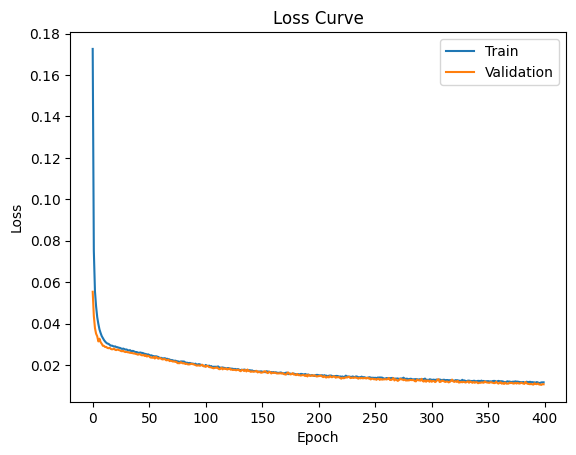

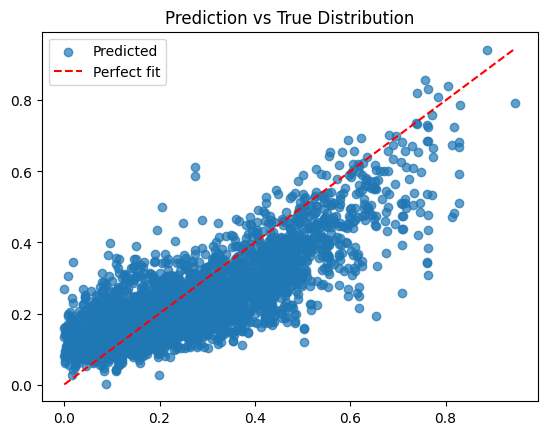

In [ ]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [ ]:
data= "Augmented Data"
encoding_method= 'K-mers Encoding'
feature_engineering= "With Feature Engineering"
run_id = 2
model_type = "MLP"
hyperparameters = {
    "epochs": 400,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


### MLP with Attention

In [ ]:
seq_len = 20        
d_model = 16 

seq_input = Input(shape=(seq_len,4), name='seq_input')
x = Dense(d_model, use_bias=False)(seq_input)  # (Projection)
position_embed = Embedding(input_dim=seq_len, output_dim=d_model)

def add_positional_encoding(t):
    pe = position_embed(tf.range(seq_len))                       
    return t + tf.expand_dims(pe, 0)

x = Lambda(add_positional_encoding, name='add_pos')(x) 

attention_output = MultiHeadAttention(num_heads=2, key_dim=d_model // 2, dropout=0.1, name='self_attn')(x, x)     

x = Add(name='attn_res')([x, attention_output])
x = LayerNormalization(name='attn_ln')(x)
attention_output = Flatten(name='gap')(x)    

x1 = Dense(256, kernel_initializer='he_normal')(attention_output)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Dense(128, kernel_initializer='he_normal')(x1)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Dense(64, kernel_initializer='he_normal')(x1)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 400,
    batch_size= 32
)

In [50]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [51]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.002
  RMSE     : 0.047
  MAE      : 0.037
  R2 Score : 0.923
  Spearman : 0.936


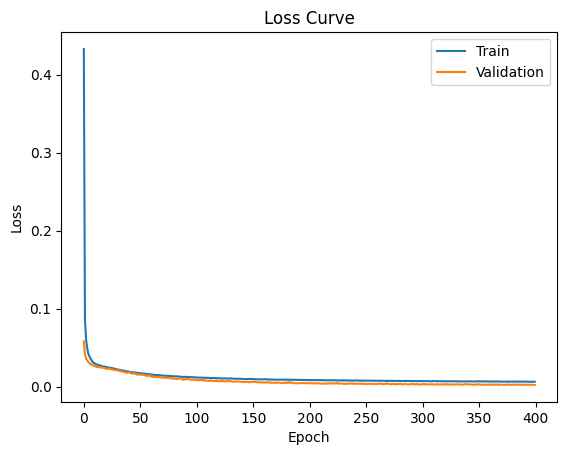

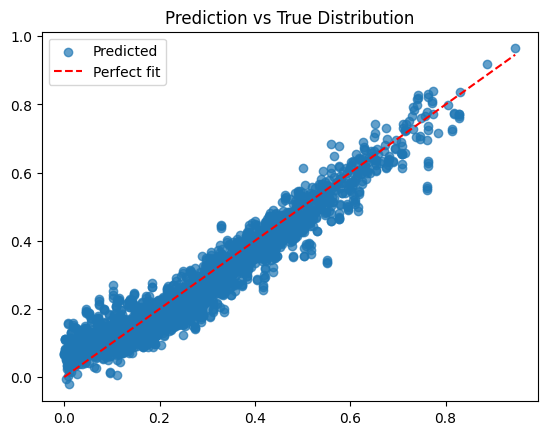

In [52]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')

ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [53]:
data= "Augmented Data"
encoding_method= '1 Hot Encoding + PE'
feature_engineering= "With Feature Engineering"
run_id = 3
model_type = "MLP + Attention"
hyperparameters = {
    "epochs": 400,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


# CNN

### Normal CNN

In [ ]:
#seq_len=20 #With one-hot encoding
#seq_input = Input(shape=(seq_len,4), name='seq_input') #With one-hot encoding
seq_len = 64  #With k-mers encoding
seq_input = Input(shape=(seq_len, 1), name="seq_input") #With k-mers encoding

x1 = Conv1D(64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(seq_input)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = GlobalMaxPooling1D()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 400,
    batch_size= 32
)

Epoch 1/400
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.3406 - mae: 0.4204 - val_loss: 0.0483 - val_mae: 0.1667
Epoch 2/400
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0503 - mae: 0.1759 - val_loss: 0.0334 - val_mae: 0.1481
Epoch 3/400
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0372 - mae: 0.1537 - val_loss: 0.0323 - val_mae: 0.1397
Epoch 4/400
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0331 - mae: 0.1450 - val_loss: 0.0304 - val_mae: 0.1423
Epoch 5/400
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0321 - mae: 0.1435 - val_loss: 0.0296 - val_mae: 0.1397
Epoch 6/400
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0306 - mae: 0.1414 - val_loss: 0.0296 - val_mae: 0.1360
Epoch 7/400
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0295 - mae: 0.1381 - val_loss: 0.0288 - val_mae: 0.1387
Epoch 8/400
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0292 - mae: 0.1374 - val_loss: 0.0290 - val_mae: 0.1354
Epoch 9/400
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/

In [33]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [34]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.017
  RMSE     : 0.129
  MAE      : 0.097
  R2 Score : 0.43
  Spearman : 0.625


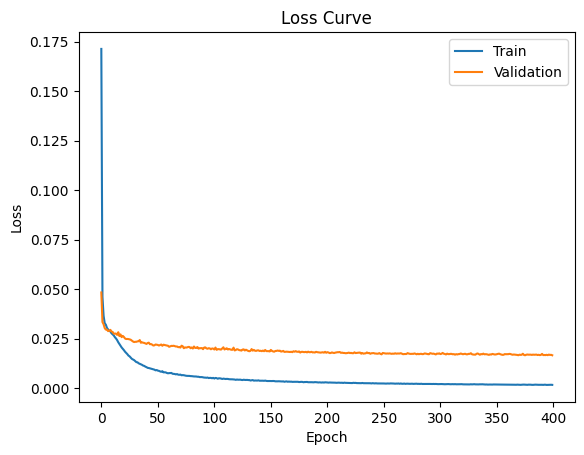

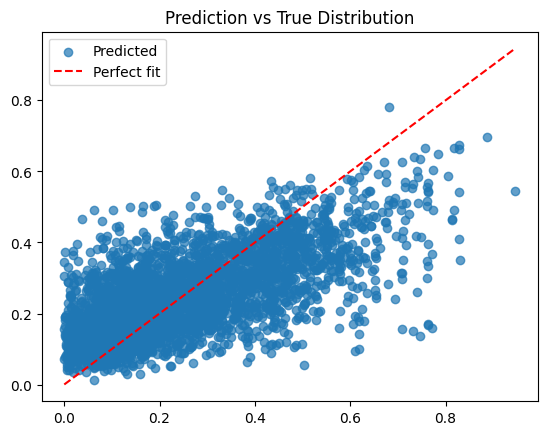

In [35]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')

ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [36]:
data= "Augmented Data"
encoding_method= 'K-mers Encoding'
feature_engineering= "With Feature Engineering"
run_id = 5
model_type = "CNN"
hyperparameters = {
    "epochs": 400,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


### CNN with Attention

In [ ]:
seq_len=20 
d_model = 16 

seq_input = Input(shape=(seq_len,4), name='seq_input') 
x = Dense(d_model, use_bias=False)(seq_input)  # (Projection)
position_embed = Embedding(input_dim=seq_len, output_dim=d_model)

def add_positional_encoding(t):
    pe = position_embed(tf.range(seq_len))                      
    return t + tf.expand_dims(pe, 0)

x = Lambda(add_positional_encoding, name='add_pos')(x)   

attention_output = MultiHeadAttention(num_heads=2, key_dim=d_model // 2, dropout=0.1, name='self_attn')(x, x)     

x = Add(name='attn_res')([x, attention_output])
x = LayerNormalization(name='attn_ln')(x)     

x1 = Conv1D(64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = Conv1D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = BatchNormalization()(x1)

x1 = GlobalMaxPooling1D()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 400,
    batch_size= 32
)


Epoch 1/400
424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.5322 - mae: 0.5452 - val_loss: 0.0668 - val_mae: 0.2043
Epoch 2/400
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0831 - mae: 0.2274 - val_loss: 0.0429 - val_mae: 0.1629
Epoch 3/400
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0506 - mae: 0.1766 - val_loss: 0.0354 - val_mae: 0.1486
Epoch 4/400
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0392 - mae: 0.1561 - val_loss: 0.0313 - val_mae: 0.1393
Epoch 5/400
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0336 - mae: 0.1449 - val_loss: 0.0289 - val_mae: 0.1359
Epoch 6/400
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0301 - mae: 0.1373 - val_loss: 0.0271 - val_mae: 0.1326
Epoch 7/400
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0281 - mae: 0.1333 - val_loss: 0.0258 - val_mae: 0.1292
Epoch 8/400
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0265 - mae: 0.1296 - val_loss: 0.0259 - val_mae: 0.1242
Epoch 9/400
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms

In [35]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [36]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.001
  RMSE     : 0.034
  MAE      : 0.023
  R2 Score : 0.96
  Spearman : 0.978


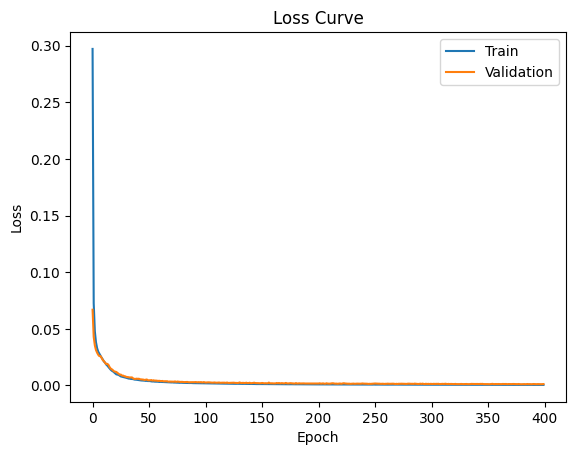

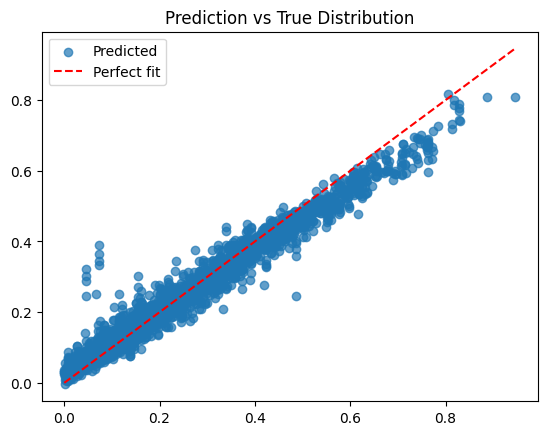

In [37]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')

ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [ ]:
data= "Augmented Data"
encoding_method= '1 Hot Encoding + PE'
feature_engineering= "With Feature Engineering"
run_id = 6
model_type = "CNN + Attention"
hyperparameters = {
    "epochs": 400,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


# BiLSTM

### Normal BiLSTM

In [ ]:
#seq_len=20 #With one-hot encoding
#seq_input = Input(shape=(seq_len,4), name='seq_input') #With one-hot encoding
seq_len = 64  #With k-mers encoding
seq_input = Input(shape=(seq_len,1), name="seq_input") #With k-mers encoding

x1 = Bidirectional(LSTM(64, return_sequences=True))(seq_input)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Bidirectional(LSTM(128, return_sequences=True))(x1)
x1 = GlobalMaxPooling1D()(x1)
x1 = BatchNormalization()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 250,
    batch_size= 32
)

Epoch 1/250
424/424 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.3501 - mae: 0.4415 - val_loss: 0.1667 - val_mae: 0.3436
Epoch 2/250
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0763 - mae: 0.2174 - val_loss: 0.0433 - val_mae: 0.1629
Epoch 3/250
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0541 - mae: 0.1823 - val_loss: 0.0367 - val_mae: 0.1507
Epoch 4/250
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0447 - mae: 0.1674 - val_loss: 0.0349 - val_mae: 0.1440
Epoch 5/250
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0386 - mae: 0.1555 - val_loss: 0.0325 - val_mae: 0.1384
Epoch 6/250
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0350 - mae: 0.1491 - val_loss: 0.0294 - val_mae: 0.1339
Epoch 7/250
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0336 - mae: 0.1460 - val_loss: 0.0286 - val_mae: 0.1325
Epoch 8/250
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0317 - mae: 0.1422 - val_loss: 0.0279 - val_mae: 0.1355
Epoch 9/250
424/424 ━━━━━━━━━━━━━━━━━━━━

In [36]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [39]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.001
  RMSE     : 0.035
  MAE      : 0.027
  R2 Score : 0.958
  Spearman : 0.975


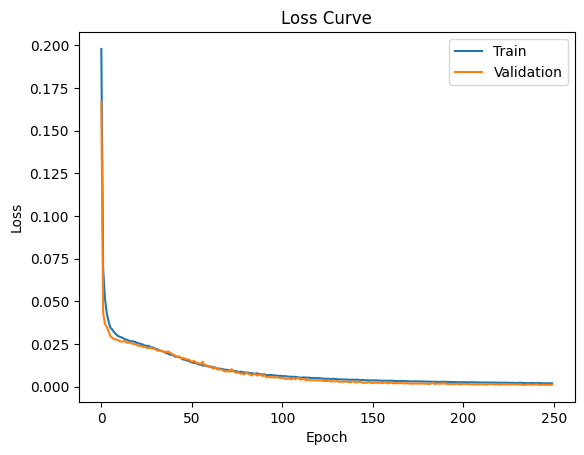

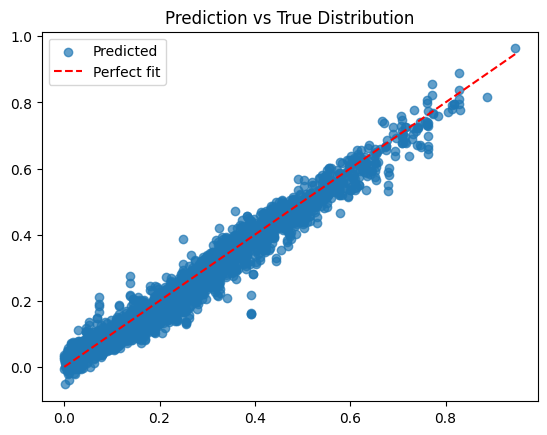

In [40]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [ ]:
data= "Augmented Data"
encoding_method= 'K-mers Encoding'
feature_engineering= "With Feature Engineering"
run_id = 8
model_type = "BiLSTM"
hyperparameters = {
    "epochs": 250,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


### BiLSTM with Attention

In [ ]:
seq_len=20 
d_model = 16 

seq_input = Input(shape=(seq_len,4), name='seq_input')  

x = Dense(d_model, use_bias=False)(seq_input)    # (Projection)
position_embed = Embedding(input_dim=seq_len, output_dim=d_model)

def add_positional_encoding(t):
    pe = position_embed(tf.range(seq_len))     
    return t + tf.expand_dims(pe, 0)

x = Lambda(add_positional_encoding, name='add_pos')(x)     

attention_output = MultiHeadAttention(num_heads=2, key_dim=d_model // 2, dropout=0.1, name='self_attn')(x, x)   

x = Add(name='attn_res')([x, attention_output])
x = LayerNormalization(name='attn_ln')(x)     

x1 = Bidirectional(LSTM(64, return_sequences=True))(x)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Bidirectional(LSTM(128, return_sequences=True))(x1)
x1 = GlobalMaxPooling1D()(x1)
x1 = BatchNormalization()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 250,
    batch_size= 32
)


Epoch 1/250
424/424 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.6665 - mae: 0.5744 - val_loss: 0.0483 - val_mae: 0.1740
Epoch 2/250
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0762 - mae: 0.2188 - val_loss: 0.0407 - val_mae: 0.1571
Epoch 3/250
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0536 - mae: 0.1824 - val_loss: 0.0353 - val_mae: 0.1466
Epoch 4/250
424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0434 - mae: 0.1650 - val_loss: 0.0320 - val_mae: 0.1406
Epoch 5/250
424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0372 - mae: 0.1523 - val_loss: 0.0316 - val_mae: 0.1386
Epoch 6/250
424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0365 - mae: 0.1523 - val_loss: 0.0303 - val_mae: 0.1371
Epoch 7/250
424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0324 - mae: 0.1436 - val_loss: 0.0298 - val_mae: 0.1367
Epoch 8/250
424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0320 - mae: 0.1434 - val_loss: 0.0291 - val_mae: 0.1349
Epoch 9/250
424/424 ━━━━━━━━━━━━━━━━━━

In [31]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [32]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.001
  RMSE     : 0.029
  MAE      : 0.022
  R2 Score : 0.971
  Spearman : 0.981


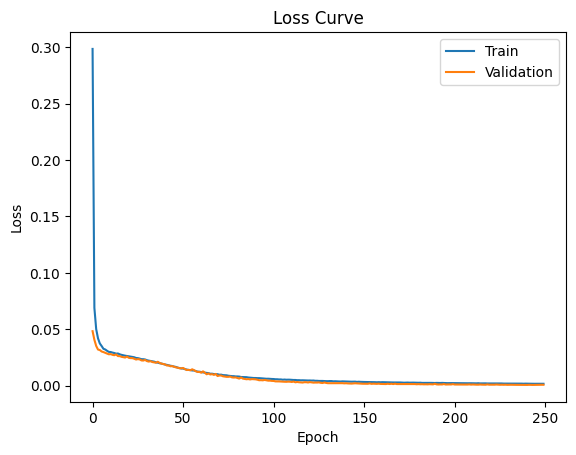

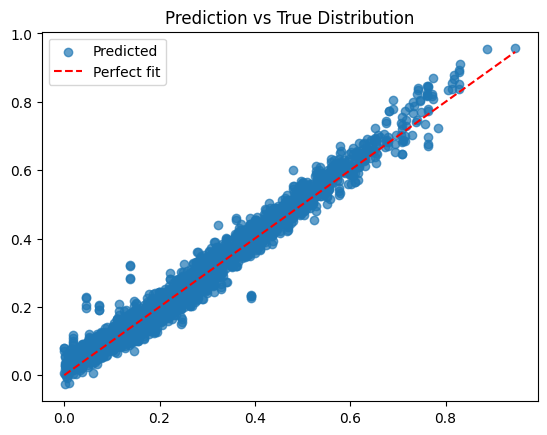

In [33]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')

ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [34]:
data= "Augmented Data"
encoding_method= '1 Hot Encoding + PE'
feature_engineering= "With Feature Engineering"
run_id = 9
model_type = "BiLSTM + Attention"
hyperparameters = {
    "epochs": 250,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done
